# MESA Sine Wave Implementation

In previous notebooks, I have struggled to implement a reasonable sine wave on the price movements of a stock. While the general form of the price action appears sinusoidal, fitting a consistant sine curve to the prices is challenging and results in great generalizations which may not be accurate enough to trade on.

The MESA Sine Wave is an implementation of solving the sine wave pattern in a way that shows promise for the basis of a trading algorithm. This notebook will attempt to implement this formulation of the wave and test it out on a sample dataset. 

#### Load sample data to use for implementation

In [6]:
import numpy as np

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sine_modules import load_set

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

key_name = 'top100alpha.csv'
data_dir = './data/screens/1yeartopperformers/'

tail = '190820.pickle'
#tail = stock + suffix

key_df = pd.read_csv(data_dir+key_name)
key_df.head()

,SYMBOL,mean,std,alpha
0,DOCU,0.669910,3.329333,0.201214
1,APG,0.542511,2.696561,0.201186
2,PRTS,1.168491,6.005884,0.194558
3,TSLA,0.973406,5.113792,0.190349
4,DKNG,0.951621,5.210704,0.182628


In [3]:
stock = key_df['SYMBOL'].loc[0]
stock

'DOCU'

In [4]:
df = load_set(stock, data_dir, tail)
df.head()

,open,high,low,close,volume,date,SYMBOL,prev_close,diff_1,pct_change,log_return
252,213.490,213.53,207.6881,209.47,2763874,2020-08-18,DOCU,207.70,1.77,0.008522,0.008486
251,202.240,209.83,201.9800,207.70,2590486,2020-08-17,DOCU,199.71,7.99,0.040008,0.039228
250,201.355,204.46,197.2100,199.71,1952648,2020-08-14,DOCU,199.38,0.33,0.001655,0.001654
249,194.220,203.85,193.6200,199.38,4048023,2020-08-13,DOCU,193.30,6.08,0.031454,0.030969
248,192.650,196.88,189.1200,193.30,4591084,2020-08-12,DOCU,191.82,1.48,0.007716,0.007686


#### Implement the mathematics portion

![MESA](./data/images/MESAsinewave.png)

In [7]:
N = 40 
j = np.arange(0, N)
j

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [16]:
xs = np.array(df.iloc[0:40]['close'])

In [19]:
len(xs)

40

In [17]:
np.cos((360 * j)/N) * xs

array([ 209.47      , -189.24175539,  131.8718498 ,  -58.24663569,
        -24.7353812 ,  100.7672639 , -164.51848464,  201.87218404,
       -208.61660688,  175.54656566, -102.01740092,    9.01066882,
         81.42174608, -154.91335426,  197.4342827 , -195.96035981,
        170.9801004 , -112.92204119,   40.9846577 ,   43.87717272,
       -120.30842768,  176.83111336, -195.78710434,  180.41551921,
       -138.44906374,   72.1525434 ,    9.24133777,  -95.79803159,
        166.15749639, -200.04641468,  194.66153074, -157.17026512,
         98.89377948,  -21.33383321,  -51.76009085,  114.48940112,
       -162.437785  ,  168.39344802, -148.74167791,  109.03156117])

In [75]:
def mesa_wave(x):
    '''
    c code adaptation here: https://github.com/TulipCharts/tulipindicators/blob/master/indicators/msw.c
    image basis https://rtmath.net/helpFinAnalysis/html/e1749c57-2542-4c8e-821f-b48ed8e0213e.htm
    
    '''
    N = len(x)
    j = np.arange(0, N)
    
    real = np.sum(np.cos((360 * j) / N) * x)
    imagin = np.sum(np.sin((360* j) / N) * x)
    
    if abs(real) > 0.001:
        phase = np.arctan(real / imagin) #+ 90
    else:
        if imagin < 0:
            phase = np.pi * - 1.0
        else:
            phase = np.pi * 1.0
    
    if real < 0.0:
        phase += 2* np.pi
    phase += np.pi / 2
    if phase < 0.0:
        phase += 2 * np.pi
    if phase > 2 * np.pi:
        phase -= 2 * np.pi
    
    
    sine = np.sin(phase)
    
    return sine

In [38]:
mesa_wave(xs)

0.44098378366492763

In [72]:
df['mesa_close'] = df['close'][::-1].rolling(5).apply(mesa_wave, raw=True)[::-1]

Text(0.5, 1.0, 'pct change')

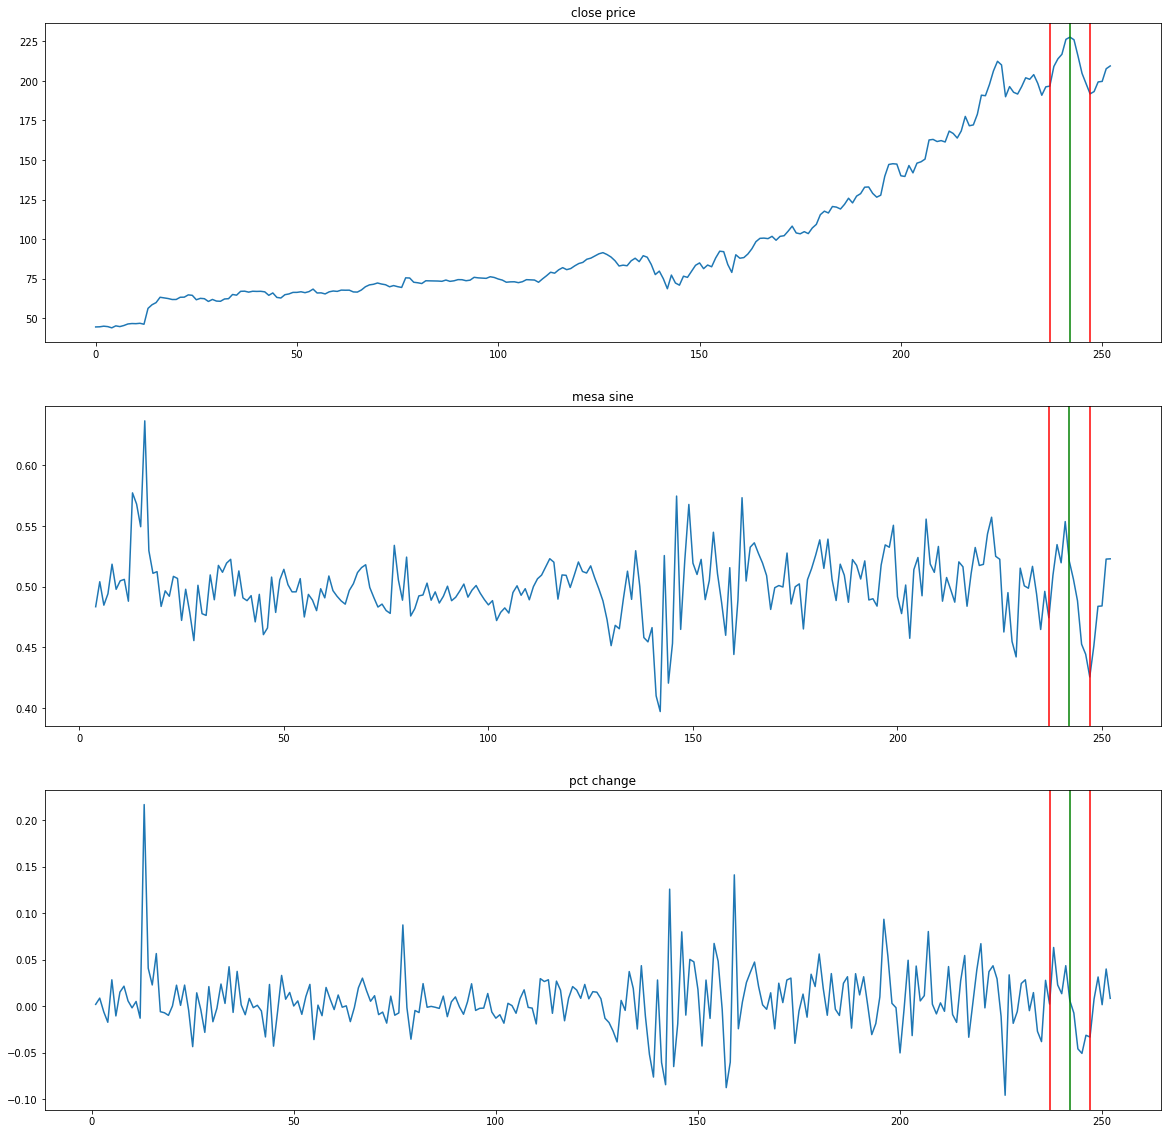

In [83]:
fig, ax = plt.subplots(3,1, figsize=(20, 20))

ax[0].plot(df['close'])
ax[0].axvline(237, c='r')
ax[0].axvline(242, c='g')
ax[0].axvline(247, c='r')
ax[0].set_title('close price')
ax[1].plot(df['mesa_close'])
ax[1].axvline(237, c='r')
ax[1].axvline(242, c='g')
ax[1].axvline(247, c='r')
ax[1].set_title('mesa sine')
ax[2].plot(df['pct_change'])
ax[2].axvline(237, c='r')
ax[2].axvline(242, c='g')
ax[2].axvline(247, c='r')
ax[2].set_title('pct change')

The wave form is very interesting here. It does seem to follow the pattern nicely. Yet, for use as a predictive indicator it will still struggle. 

It would be better if the values ranged from -1 to 1 as they do in thinkorswim. Lets try implementing it on the daily % change chart. 

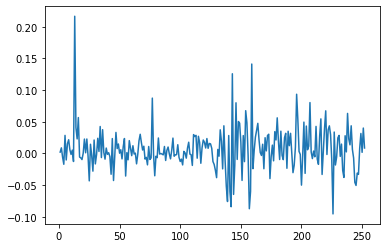

In [78]:
plt.plot(df['pct_change'])

In [79]:
df['pct_mesa_wave'] = df['pct_change'][::-1].rolling(5).apply(mesa_wave, raw=True)[::-1]

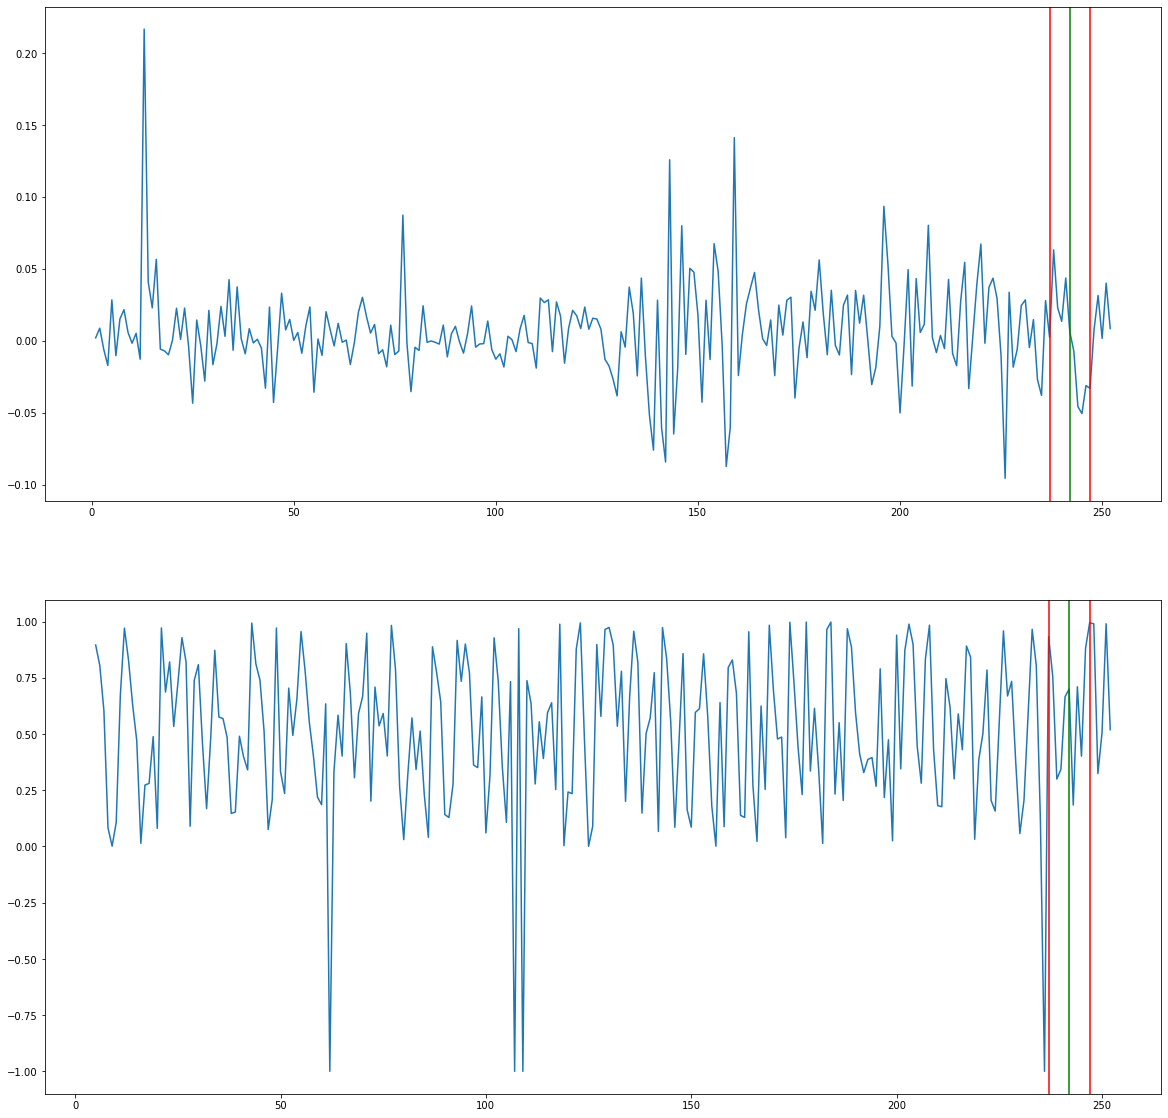

In [81]:
fig, ax = plt.subplots(2,1, figsize=(20, 20))

ax[0].plot(df['pct_change'])
ax[0].axvline(237, c='r')
ax[0].axvline(242, c='g')
ax[0].axvline(247, c='r')
ax[1].plot(df['pct_mesa_wave'])
ax[1].axvline(237, c='r')
ax[1].axvline(242, c='g')
ax[1].axvline(247, c='r')

Implemented on the % change column, the mesa sine wave seems a bit meaningless. If anything, the % change column already closely resembles the MESA sine wave on thee price. 

In [85]:
description = df['mesa_close'].describe()
description

count    249.000000
mean       0.500300
std        0.027543
min        0.397125
25%        0.488086
50%        0.499419
75%        0.515819
max        0.636770
Name: mesa_close, dtype: float64

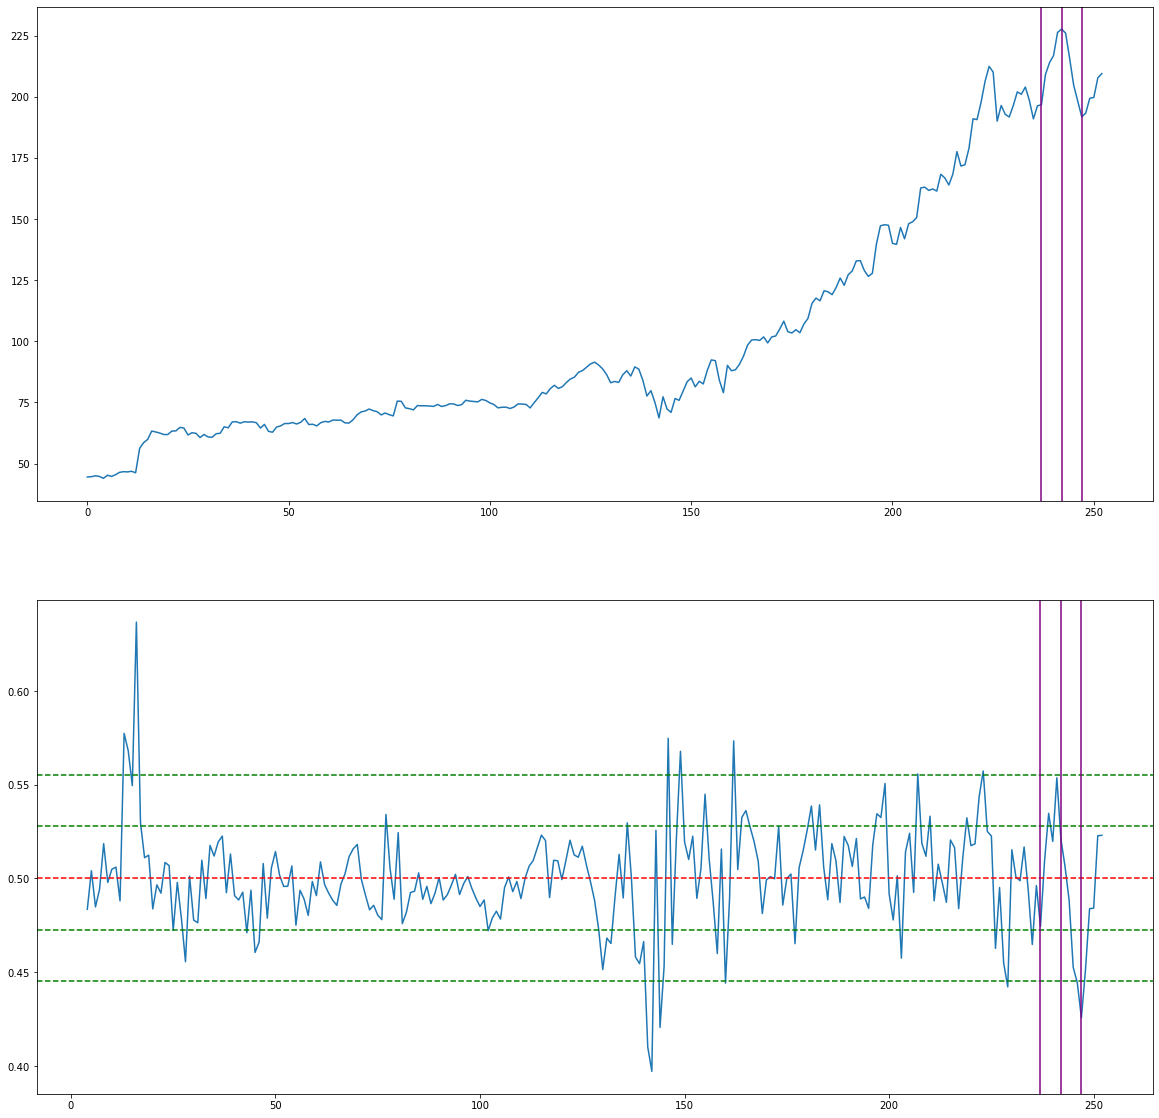

In [93]:
fig, ax = plt.subplots(2,1, figsize=(20, 20))

ax[0].plot(df['close'])
ax[1].plot(df['mesa_close'])
ax[1].axhline(description['mean'], c='r', linestyle='dashed')
ax[1].axhline(description['mean'] + description['std'], c='g', linestyle='dashed')
ax[1].axhline(description['mean'] + description['std'] * 2, c='g', linestyle='dashed')
ax[1].axhline(description['mean'] - description['std'], c='g', linestyle='dashed')
ax[1].axhline(description['mean'] - description['std'] * 2, c='g', linestyle='dashed')
ax[0].axvline(237, c='purple')
ax[0].axvline(242, c='purple')
ax[0].axvline(247, c='purple')
ax[1].axvline(237, c='purple')
ax[1].axvline(242, c='purple')
ax[1].axvline(247, c='purple')